# Step #1: Explore and prep the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
df = pd.read_csv('airline dataset updated - v2.csv')

# List and drop columns that are less related to flight status
cols_to_drop = ['Passenger ID', 'First Name', 'Last Name', 'Gender', 'Age', 'Nationality']
df = df.drop(columns=cols_to_drop)

# Drop missing values
df.dropna(inplace=True)
df.head(10)

,Airport Name,Airport Country Code,Country Name,Airport Continent,Continents,Departure Date,Arrival Airport,Pilot Name,Flight Status
0,Coldfoot Airport,US,United States,NAM,North America,6/28/2022,CXF,Fransisco Hazeldine,On Time
1,Kugluktuk Airport,CA,Canada,NAM,North America,12/26/2022,YCO,Marla Parsonage,On Time
2,Grenoble-Isère Airport,FR,France,EU,Europe,1/18/2022,GNB,Rhonda Amber,On Time
3,Ottawa / Gatineau Airport,CA,Canada,NAM,North America,9/16/2022,YND,Kacie Commucci,Delayed
4,Gillespie Field,US,United States,NAM,North America,2/25/2022,SEE,Ebonee Tree,On Time
5,Coronel Horácio de Mattos Airport,BR,Brazil,SAM,South America,06-10-2022,LEC,Inglis Dolley,On Time
6,Duxford Aerodrome,GB,United Kingdom,EU,Europe,10/30/2022,QFO,Stanislas Tiffin,Cancelled
7,Maestro Wilson Fonseca Airport,BR,Brazil,SAM,South America,04-07-2022,STM,Sharyl Eastmead,Cancelled
8,Venice Marco Polo Airport,IT,Italy,EU,Europe,8/20/2022,VCE,Daryn Bardsley,On Time
9,Vermilion Airport,CA,Canada,NAM,North America,04-06-2022,YVG,Alameda Carlyle,On Time


In [3]:
df.shape

(98619, 9)

In [4]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98619 entries, 0 to 98618
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Airport Name          98619 non-null  object
 1   Airport Country Code  98619 non-null  object
 2   Country Name          98619 non-null  object
 3   Airport Continent     98619 non-null  object
 4   Continents            98619 non-null  object
 5   Departure Date        98619 non-null  object
 6   Arrival Airport       98619 non-null  object
 7   Pilot Name            98619 non-null  object
 8   Flight Status         98619 non-null  object
dtypes: object(9)
memory usage: 6.8+ MB


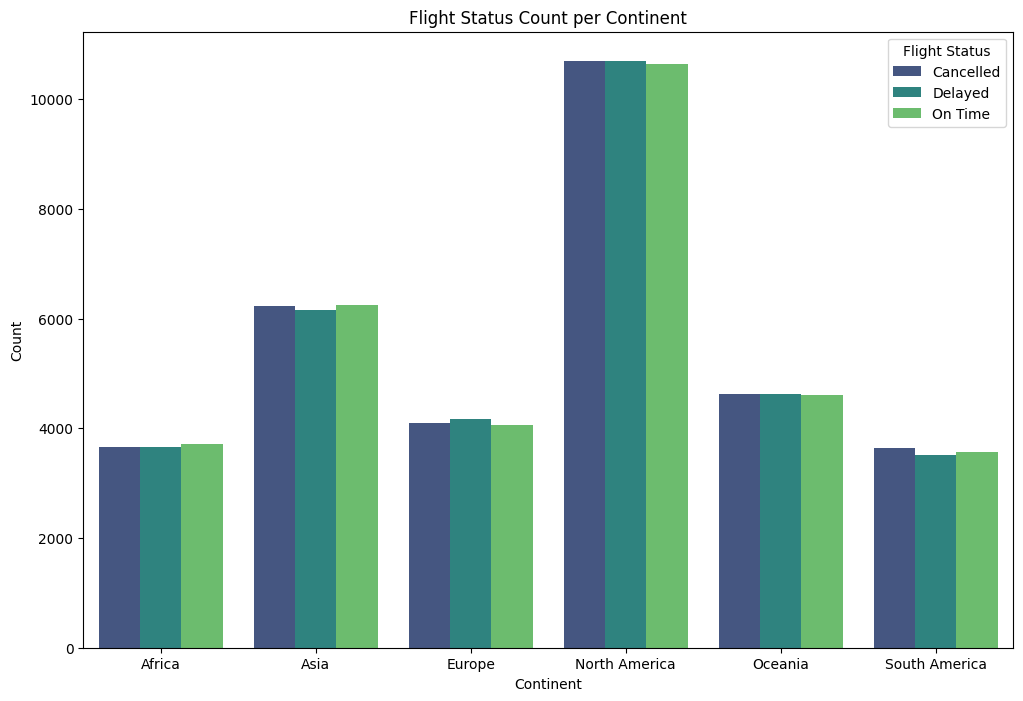

In [29]:


# Count the number of flights for each continent and flight status
flight_status_counts = df.groupby(['Continents', 'Flight Status']).size().reset_index(name='Count')

# Create a bar plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Continents', y='Count', hue='Flight Status', data=flight_status_counts, palette='viridis')
plt.title('Flight Status Count per Continent')
plt.xlabel('Continent')
plt.ylabel('Count')
plt.show()


# Step #2: Feature Engineering

In [5]:
# Feature preparation: Extract day of the week and month from departure date
df['Departure Date'] = pd.to_datetime(df['Departure Date'], format = 'mixed')
df['Day_of_Week'] = df['Departure Date'].dt.dayofweek
df['Month'] = df['Departure Date'].dt.month


# Concatenate date and continent to create new features
df['Continent_Date'] = df['Airport Continent'] + '_' + df['Departure Date'].astype(str)

le_continent = LabelEncoder()
df['Continent_Code'] = le_continent.fit_transform(df['Airport Continent'])
df['Date_Code'] = pd.to_datetime(df['Departure Date']).dt.dayofyear
df['Continent_Date'] = df['Continent_Code'] * 1000 + df['Date_Code']


# Prep the features
features = ['Airport Name', 'Airport Country Code', 'Country Name', 'Airport Continent', 'Continents', 'Pilot Name', 'Day_of_Week', 'Month', 'Arrival Airport', 'Continent_Date']

X = df[features].copy()

# Target Variable 
y = df['Flight Status'].apply(lambda x: 0 if x in ['Cancelled', 'Delayed'] else 1)

# Label Encoding for categorical variables
label_encoders = {}
for feature in ['Airport Name', 'Airport Country Code', 'Country Name', 'Airport Continent', 'Continents', 'Pilot Name', 'Arrival Airport']:
    le = LabelEncoder()
    X.loc[:, feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le


# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.2, random_state= 77)


# Step #3: Initialize and train the classifier

In [31]:
xgb = XGBClassifier(eval_metric= 'logloss')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

# Step #4: Predict and evaluate the model

In [32]:
# Predict
y_pred = xgb.predict(X_test)

# Evaluate 
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.6590955181504766
              precision    recall  f1-score   support

           0       0.66      0.98      0.79     13111
           1       0.33      0.02      0.03      6613

    accuracy                           0.66     19724
   macro avg       0.50      0.50      0.41     19724
weighted avg       0.55      0.66      0.54     19724



In [33]:

num_features = X_train.shape[1]
feature_importance = pd.DataFrame(index=range(num_features), data = xgb.feature_importances_)
feature_importance = feature_importance.sort_values(0, ascending = False)

feature_importance.head(10)

,0
8,0.123567
0,0.122248
5,0.121989
9,0.119686
2,0.117588
1,0.109031
7,0.105541
6,0.098924
3,0.081426
4,0.000000


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

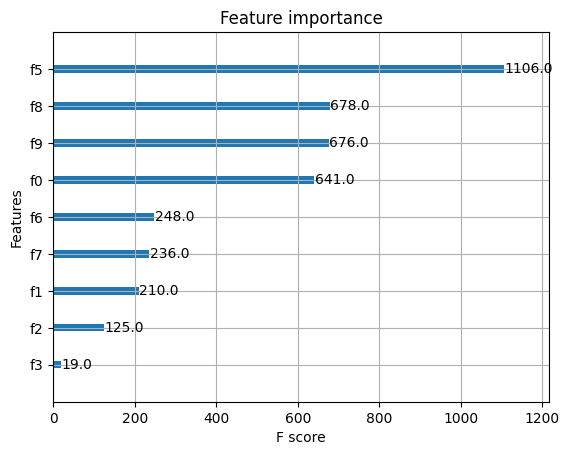

In [34]:
from xgboost import plot_importance
plot_importance(xgb)